# Histopathologic Cancer Detection
Cancer detection is an important area in the field of biomedical data science. AI-assisted classification of tissues can help physicians detect cancerous tissues, preventing false negatives and speeding up medical diagnostics. Here, we utilize Convolutional Neural Networks (CNNs) to help classify the cancer tissue. We will train and evaluate a number of CNN architectures. In consideration of time and resources, architectures may be implemented in a slightly modified form.
1. A **VGG-16** architecture strings together 2 convolutions with 3x3 filters and a 2x2 max pool and 3 convolutions with 3x3 filters and another 2x2 max pool. The output is then fed to multiple dense layers for classification.<br>
    ![VGG-16](https://github.com/benjamin-ahlbrecht/histopathologic-caner-detection/blob/main/assets/vgg-16.png?raw=1)
2. An **AlexNet** architectures begins with an 11x11 convolutional filter followed by a 3x3 max pool. This is followed by a smaller, 5x5 convolution and another 3x3 max pool. Last, a series of 3 3x3 convolutions is followed by a final 3x3 max pool. For classification, multiple dense layers follow.<br>
    ![AlexNet](https://github.com/benjamin-ahlbrecht/histopathologic-caner-detection/blob/main/assets/alex-net.png?raw=1)
3. The simpler **LeNet-5** architecture uses strings together 2 5x5 convolutional layers followed by a 2x2 avg pool. For classification, it is followed by several dense layers.<br>
    ![LeNet-5](https://github.com/benjamin-ahlbrecht/histopathologic-caner-detection/blob/main/assets/le-net.png?raw=1)

## Data Downloading
We will utilize the Kaggle CLI to 

In [ ]:
%%bash
# Install the Kaggle cli
pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%bash
%%time
# Download and unzip the kaggle competition
mkdir data
cd data

printf "Downloading the HistoPathologic Cancer Detection Dataset\n"
kaggle competitions download -c histopathologic-cancer-detection

printf "Unzipping the Dataset\n"
unzip histopathologic-cancer-detection.zip

In [1]:
%%bash
cd data

pwd
du --block-size=G

echo ""
ls -la

/home/benjamin/Git/histopathologic-caner-detection/src/data
1G	./train/.ipynb_checkpoints
1G	./train/.comments
6G	./train
2G	./test
14G	.

total 6721684
drwxr-xr-x 4 benjamin benjamin       4096 Sep  1 20:13 .
drwxr-xr-x 4 benjamin benjamin       4096 Sep 18 16:15 ..
-rw-r--r-- 1 benjamin benjamin 6773228425 Sep  1 09:57 histopathologic-cancer-detection.zip
-rw-r--r-- 1 benjamin benjamin   76607678 Sep  1 20:13 Miniconda3-latest-Linux-x86_64.sh
-rw-r--r-- 1 benjamin benjamin    2470703 Dec 12  2019 sample_submission.csv
drwxr-xr-x 2 benjamin benjamin    4329472 Sep  1 09:57 test
drwxr-xr-x 4 benjamin benjamin   16805888 Sep  1 11:11 train
-rw-r--r-- 1 benjamin benjamin    9461084 Dec 12  2019 train_labels.csv


## Data Source and Ingestion 
Here, we perform some necessary preliminary actions: loading packages, obtaining the directory and file paths for the source directory, the data directory, the data training directory, the data testing directory, and the metadata files containing the training labels for each respective training image. The `train_labels.csv` is loaded in as a Pandas dataframe, and we append the full path of the image to the dataframe to streamline data ingestion.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import random
import os

from PIL import Image

from matplotlib import pyplot as plt
import altair as alt

import tensorflow as tf
from tensorflow import keras

np.set_printoptions(precision=3)

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print("Not running on TPU")


Not running on TPU


In [4]:
# Obtain relevant paths
DIR_SRC = os.getcwd()
DIR_DATA = f"{DIR_SRC}/data"
DIR_DATA_TRAIN = f"{DIR_DATA}/train"
DIR_DATA_TEST = f"{DIR_DATA}/test"

# Store the location of our training labels dataset
FILE_METADATA_TRAIN = f"{DIR_DATA}/train_labels.csv"

In [5]:
print(f"""\
Source Directory:     {DIR_SRC}
Data Directory:       {DIR_DATA}
Data Train Directory: {DIR_DATA_TRAIN}
Data Test Directory:  {DIR_DATA_TEST}
Training Labels File: {FILE_METADATA_TRAIN}
""")

Source Directory:     /home/benjamin/Git/histopathologic-caner-detection/src
Data Directory:       /home/benjamin/Git/histopathologic-caner-detection/src/data
Data Train Directory: /home/benjamin/Git/histopathologic-caner-detection/src/data/train
Data Test Directory:  /home/benjamin/Git/histopathologic-caner-detection/src/data/test
Training Labels File: /home/benjamin/Git/histopathologic-caner-detection/src/data/train_labels.csv



In [6]:
# Load in the training labels as a pandas dataframe
METADATA_TRAIN = pd.read_csv(FILE_METADATA_TRAIN)

# Add in the full path to the id, so we can grab it easier
METADATA_TRAIN["path"] = DIR_DATA_TRAIN + "/" + METADATA_TRAIN["id"] + ".tif"

In [7]:
METADATA_TRAIN.head(10)

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/home/benjamin/Git/histopathologic-caner-detec...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/home/benjamin/Git/histopathologic-caner-detec...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/home/benjamin/Git/histopathologic-caner-detec...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/home/benjamin/Git/histopathologic-caner-detec...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/home/benjamin/Git/histopathologic-caner-detec...
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0,/home/benjamin/Git/histopathologic-caner-detec...
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1,/home/benjamin/Git/histopathologic-caner-detec...
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1,/home/benjamin/Git/histopathologic-caner-detec...
8,559e55a64c9ba828f700e948f6886f4cea919261,0,/home/benjamin/Git/histopathologic-caner-detec...
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0,/home/benjamin/Git/histopathologic-caner-detec...


## Exploratory Data Analysis
An exploratory data analysis on images may be difficult to perform. However, there are a few things we can do to ensure that model building will go well: We can display random images alongside their label to gain an intuitive idea of what we are trying to achieve, and we can plot a histogram of the training label frequencies to see how much data we actually have and how balanced our classes are. The Kaggle competition indicates a sample as positive for cancer if there exists cancerous tissue in a $32 \times 32$ pixel region at the center of the image. To emphasize this, we will highlight the area in our visualizations.

In [8]:
def tif_to_numpy(fname):
    """Load a .tif image as a NumPy array given the file name.
    
    Parameters
    ----------
    fname: string
        The input string for the .tif image
    
    Returns
    -------
    image: np.ndarray
        The 3D NumPy array corresponding to the iamge
    """
    # Load the tif as an Image
    image = Image.open(fname)
    return np.array(image)


def extract_sub_square_mask(arr, l):
    """Extracts a sub-square mask from a square NumPy array of size
    (l x l x ...), wherein all values are 0 except the square of length l in
    the center.
    
    Parameters
    ----------
    arr: np.ndarray
        The square NumPy array to sub-square mask.
    l: int
        The desired side-length of the center square to mask
        
    Returns
    -------
    arr_mask: np.ndarray
        The sub-squared and masked NumPy array. All values are False except the
        elements present in the sub-square.
    """
    n = arr.shape[0]
    
    start = n - (l * 2)
    end = n - l
    
    arr_mask = np.full((n, n), False)
    arr_mask[start:end, start:end] = True
    
    return arr_mask


def extract_sub_square(arr, l):
    """Extacts a sub-square from a square NumPy array of size
    (l x l x ...).
    
    Parameters
    ----------
    arr: np.ndarray
        The square NumPy array to subset.
    l: int
        The desired side-length of the center square to extract.
    
    Returns
    -------
    arr_sub: np.ndarray
        The sub-squared array
    """
    n = arr.shape[0]
    
    start = n - (l * 2)
    end = n - l
    
    arr_sub = arr[start:end, start:end]
    return arr_sub
    


def display_random_images(metadata_train, n=3):
    """Display n*n random images as a matplotlib figure from the train_csv dataframe
    
    Parameters
    ----------
    metadata_train: list of strings
        The input metadata
        
    n: int
        The number of images to select for a row. A total of n^2 images will be
        selected.
    """
    n2 = n * n
    indices = random.sample(range(n2), n2)
    
    # Extract the images and their label
    image_labels = [metadata_train["label"][i] for i in indices]
    
    # Load in the images
    images = [tif_to_numpy(metadata_train["path"][i]) for i in indices]
    
    # Display each image in a subplot
    fig, ax = plt.subplots(figsize=(3.5*n, 3.5*n), ncols=n, nrows=n, tight_layout=True)
    
    # Generate a mask to detect the center of the image
    mask = extract_sub_square_mask(images[0], 32)
    print(mask.shape)
    
    # k will serve as a pointer to our image and label
    k = 0
    
    for i in range(n):
        for j in range(n):
            # Plot the individual image in an axis
            image = images[k]
            image[~mask] = image[~mask] * 0.5
            
            # Highlight the center 32 x 32 region
            ax[i, j].axis("off")
            ax[i, j].imshow(image)
            ax[i, j].set_title(f"Label: {image_labels[k]}")
            
            k += 1

(96, 96)


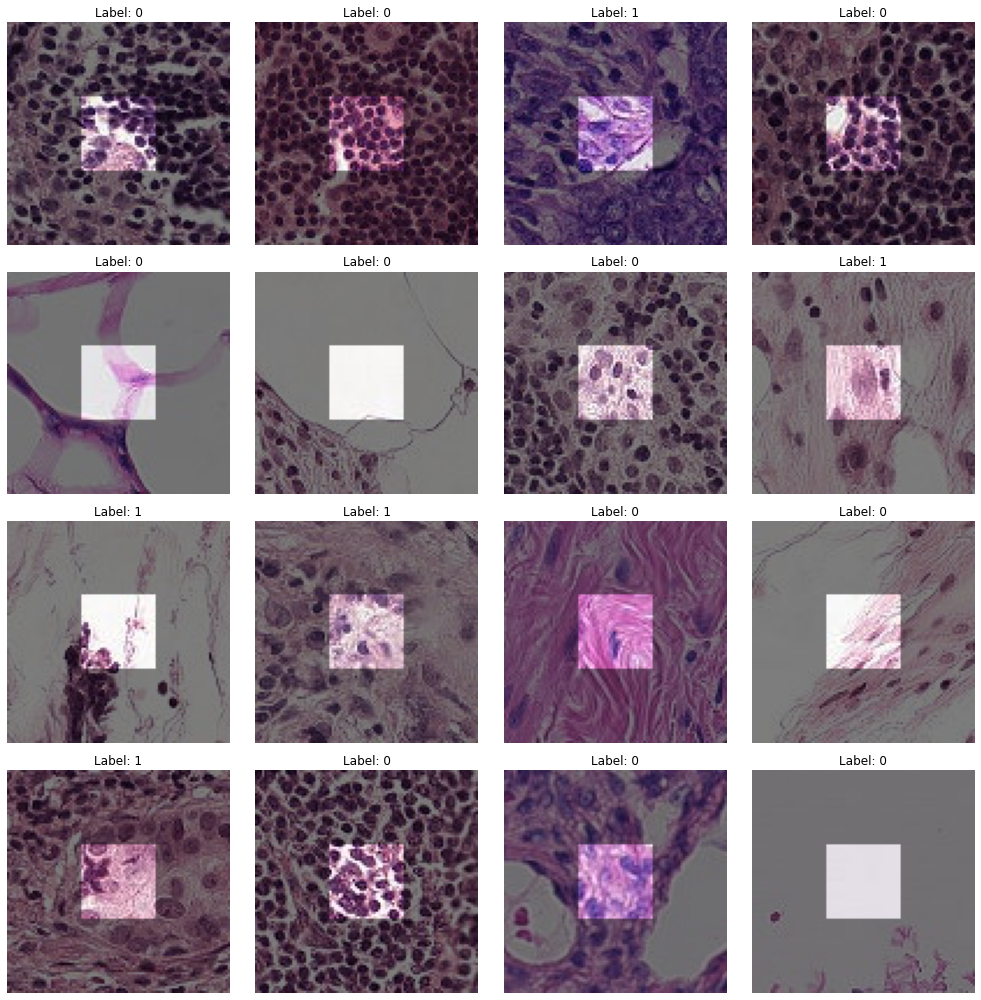

In [9]:
display_random_images(METADATA_TRAIN, n=4)

In [10]:
# Generate a figure to determine the distribution of training labels
source = pd.DataFrame({
    "Label": ["0 (No Cancer)", "1 (Cancer)"],
    "Count": [sum(METADATA_TRAIN["label"] == 0), sum(METADATA_TRAIN["label"] == 1)]
})


(
    alt.Chart(source)
    .mark_bar()
    .encode(
        x=alt.X("Label:O", axis=alt.Axis(labelAngle=0)),
        y=alt.Y("Count:Q")
    )
    .properties(width=500, height=300)
)

alt.Chart(...)

## Data Preprocessing
We will utilize TensorFlow datasets to preprocess our data. Image data will benefit from normalization and will require shuffling to ensure that the data is i.i.d. We will also split the training data to include a validation set to help tune our CNN models.

In [44]:
# Create the full dataset of the metadata
IMAGE_PATHS = METADATA_TRAIN["path"]
IMAGE_LABELS = np.array(METADATA_TRAIN["label"]).reshape(-1, 1)

# Define how many samples compose a single epoch (buffer)
n = len(IMAGE_PATHS)

buffer_size = 20_000

if buffer_size is None:
    buffer_size = n
    
# Define how we will split the dataset
train_proportion = 0.75
train_size = np.floor(n * train_proportion)

assert buffer_size <= train_size,\
    f"Buffer size ({buffer_size}) must be smaller than the train size ({train_size})"

# Define the image size to feed into the CNN
# Labels are assigned based on (32 x 32) square; add some padding for convolutions
padding = 4
image_length = 32 + padding

print(f"""\
Size of Dataset:       {n}
Buffer Size:           {buffer_size}
Train Proportion:      {train_proportion}
Train Size:            {train_size}
Validation Proportion: {1 - train_proportion}
Validation Size:       {np.floor(buffer_size * (1 - train_proportion))}
Image Padding:         {padding}
Image Size:            {image_length} x {image_length}
""")


# Create a data generator that we can feed the dataset individual samples without running out of RAM
def image_generator(image_length=32):
    """Utilize the IMAGE_PATHS and IMAGE_LABELS global variables to load images
    in a generator form. This avoids memory overflow from processing all images
    at once.
    
    Parameters
    ----------
    image_length: int
        The side of a single side length to subset the image.
        
    Returns
    -------
    image: np.ndarray
        The resulting image in the form of a NumPy array. 
    """
    for path, label in zip(IMAGE_PATHS, IMAGE_LABELS):
        image = tif_to_numpy(path)
        image = extract_sub_square(image, image_length)
        yield (image, label)
        

# TODO: apply image_z = (image - mean(image) / std(image))... Tensors are hard
def normalization(image):
    """Normalize an image across each RGB channel using the z-score.
    
    Parameters
    ----------
    image : tf.tensor
        The input image
    
    Returns
    -------
    image_z : tf.tensor
        The z-score normalized image
    """ 
    image_z = image / 255
    
    return image_z

Size of Dataset:       220025
Buffer Size:           20000
Train Proportion:      0.75
Train Size:            165018.0
Validation Proportion: 0.25
Validation Size:       5000.0
Image Padding:         4
Image Size:            36 x 36



In [45]:
# Create our full dataset, which we cache after loading, cropping, and normalizing the image
dataset_full = (
    tf.data.Dataset.from_generator(
        lambda: image_generator(image_length),
        output_signature=(
            tf.TensorSpec(shape=(image_length, image_length, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.int16)
        )
    )
    .map(
        lambda x, y: (normalization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .shuffle(len(IMAGE_LABELS))
)



# Split the dataset into a training set, take batches, and prefetch for training
dataset_train = (
    dataset_full.take(train_size)
    .cache()
    .shuffle(buffer_size, reshuffle_each_iteration=True)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


# Do the same thing to produce a validation set
dataset_validation = (
    dataset_full.skip(train_size)
    .cache()
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

## Model Building
Here, we implement the 3 CNN models we discussed before. This concerns bulding and compiling the TensorFlow models. Since 

In [46]:
lenet = keras.Sequential([
    keras.layers.Input((36, 36, 3)),
    keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation="relu"),
    keras.layers.AveragePooling2D(),

    keras.layers.Conv2D(filters=12, kernel_size=(5, 5), activation="relu"),
    keras.layers.AveragePooling2D(),

    keras.layers.Flatten(),
    
    keras.layers.Dense(units=120, activation="relu"),
    keras.layers.Dense(units=40, activation="relu"),
    keras.layers.Dense(units=1, activation="sigmoid")
])

lenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)

callback = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    restore_best_weights=True
)

lenet.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_16 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 12)        1812      
                                                                 
 average_pooling2d_17 (Avera  (None, 6, 6, 12)         0         
 gePooling2D)                                                    
                                                                 
 flatten_8 (Flatten)         (None, 432)               0         
                                                                 
 dense_24 (Dense)            (None, 120)              

In [47]:
%%time
history = lenet.fit(
    dataset_train,
    epochs=50,
    verbose=1,
    callbacks=[callback],
    validation_data=dataset_validation
)

Epoch 1/50


2022-09-18 16:42:03.158591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 12922 of 220025
2022-09-18 16:42:13.158509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 25538 of 220025
2022-09-18 16:42:23.159927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 37907 of 220025
2022-09-18 16:42:33.159444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 49947 of 220025
2022-09-18 16:42:43.159078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 61842 of 220025
2022-09-18 16:42:53.159029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 74275 of 220025
2022-09-18 16:43:03.158809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:3

      6/Unknown - 179s 22ms/step - loss: 0.6905 - accuracy: 0.5729 - auc: 0.4751

2022-09-18 16:44:51.007521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-18 16:44:51.007560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 20000
2022-09-18 16:44:51.008122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 20000
2022-09-18 16:44:51.008141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 20000
2022-09-18 16:44:51.008151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4 of 20000
2022-09-18 16:44:51.008160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 20000
2022-09-18 16:44:51.008169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6 of 20000
202

   2577/Unknown - 236s 22ms/step - loss: 0.5074 - accuracy: 0.7590 - auc: 0.8213

2022-09-18 16:45:58.641337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 12592 of 220025
2022-09-18 16:46:08.641786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 25075 of 220025
2022-09-18 16:46:18.641633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 37569 of 220025
2022-09-18 16:46:28.641311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 49713 of 220025
2022-09-18 16:46:38.641189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 61873 of 220025
2022-09-18 16:46:48.641186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 74592 of 220025
2022-09-18 16:46:58.641311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:3

2579/2579 [==============================] - 415s 92ms/step - loss: 0.5075 - accuracy: 0.7589 - auc: 0.8212 - val_loss: 0.5777 - val_accuracy: 0.7028 - val_auc: 0.8303
Epoch 2/50
2579/2579 [==============================] - 59s 23ms/step - loss: 0.4787 - accuracy: 0.7785 - auc: 0.8438 - val_loss: 0.4767 - val_accuracy: 0.7786 - val_auc: 0.8519
Epoch 3/50
2579/2579 [==============================] - 59s 23ms/step - loss: 0.4652 - accuracy: 0.7857 - auc: 0.8531 - val_loss: 0.4699 - val_accuracy: 0.7832 - val_auc: 0.8590
Epoch 4/50
2579/2579 [==============================] - 59s 23ms/step - loss: 0.4520 - accuracy: 0.7952 - auc: 0.8617 - val_loss: 0.4506 - val_accuracy: 0.7953 - val_auc: 0.8685
Epoch 5/50
2579/2579 [==============================] - 60s 23ms/step - loss: 0.4422 - accuracy: 0.8002 - auc: 0.8681 - val_loss: 0.4416 - val_accuracy: 0.7956 - val_auc: 0.8783
Epoch 6/50
2579/2579 [==============================] - 60s 23ms/step - loss: 0.4341 - accuracy: 0.8052 - auc: 0.8734 - 

In [50]:
# Create a dataframe from the training history
source = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={
        "index": "Epoch",
        "loss": "Loss",
        "accuracy": "Accuracy",
        "auc": "AUC",
        "val_loss": "Validation Loss",
        "val_accuracy": "Validation Accuracy",
        "val_auc": "Validation AUC"
    })
)

source["Epoch"] += 1


# Melt the data for multi-series plotting
source_melt = source.melt(id_vars="Epoch")

display(source)
display(source_melt)

,Epoch,Loss,Accuracy,AUC,Validation Loss,Validation Accuracy,Validation AUC
0,1,0.507464,0.758941,0.821221,0.577681,0.702765,0.830322
1,2,0.478731,0.778461,0.843764,0.476677,0.778610,0.851923
2,3,0.465180,0.785714,0.853082,0.469881,0.783228,0.858956
3,4,0.452015,0.795162,0.861679,0.450552,0.795281,0.868455
4,5,0.442173,0.800179,0.868123,0.441648,0.795590,0.878316
5,6,0.434128,0.805209,0.873393,0.430084,0.805461,0.879717
6,7,0.426311,0.808833,0.878261,0.418062,0.812878,0.884017
7,8,0.420193,0.812008,0.882234,0.437853,0.799207,0.881873
8,9,0.412825,0.815329,0.886474,0.425630,0.802716,0.885100
9,10,0.406629,0.818965,0.890129,0.399228,0.823223,0.894390


,Epoch,variable,value
0,1,Loss,0.507464
1,2,Loss,0.478731
2,3,Loss,0.465180
3,4,Loss,0.452015
4,5,Loss,0.442173
...,...,...,...
175,26,Validation AUC,0.916589
176,27,Validation AUC,0.921889
177,28,Validation AUC,0.918798
178,29,Validation AUC,0.914759


In [51]:
c1 = (
    alt.Chart(source.melt(["Epoch"], ["Loss", "Validation Loss"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="Loss (Binary Cross Entropy)", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)

c2 = (
    alt.Chart(source.melt(["Epoch"], ["Accuracy", "Validation Accuracy"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="Accuracy", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)

c3 = (
    alt.Chart(source.melt(["Epoch"], ["AUC", "Validation AUC"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="AUC (Area Under Curve)", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)


c4 = (
    alt.hconcat(c1, c2, c3)
    .resolve_scale(color="independent", strokeDash="independent")
    .configure_view(stroke=None)
)

display(c4)

alt.HConcatChart(...)